## What we need 

Get data from WRDS --> is this through openAP

get fama french factors? 

How do we get the long-short positions?? like how do we see the returns?

are we able to get wrds connection or should we get a file downloaded from you 

will we be able to use gridsearchCV to run multiple models at once?

In [1]:
DEV = False # will shrink datasets after loading if true 


In [7]:
import pandas as pd
import polars as pl

import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
crsp = pd.read_csv('crsp_data.csv')
crsp.info()

# for speedy dev, pick 20 permnos at random (with seed)
if DEV == True:
    np.random.seed(123)
    permnos = crsp['permno'].unique()
    permnos = np.random.choice(permnos, size=20, replace=False)
    crsp = crsp[crsp['permno'].isin(permnos)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   permno  int64  
 1   date    object 
 2   ret     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 92.6+ MB


In [4]:
# crsp = pl.from_pandas(crsp)

crsp['date'] = pd.to_datetime(crsp['date'])

cleancrsp = crsp.query('ret.notnull() and date.dt.year >= 1975')
#crsp["ret"].is_not_null(), crsp['date'].dt.year() >= 1975) 
# keep only the data that has return and after 1975

len(cleancrsp['ret'].notnull()) # check that no null values in ret
len(cleancrsp['ret'].notnull()) == len(cleancrsp) # check that all ret values are not null

cleancrsp


,permno,date,ret
1,10000,1986-02-28,-25.7143
2,10000,1986-03-31,36.5385
3,10000,1986-04-30,-9.8592
4,10000,1986-05-30,-22.2656
5,10000,1986-06-30,-0.5025
...,...,...,...
4047625,93436,2024-08-30,-7.7391
4047626,93436,2024-09-30,22.1942
4047627,93436,2024-10-31,-4.5025
4047628,93436,2024-11-29,38.1469


### Some EDA

In [5]:
# max_idx = cleancrsp['ret'].argmax()

# cleancrsp.iloc[max_idx-5:max_idx+5] # this seems like an outlier for sure, not to be included in the data --> company is black stone minerals. 

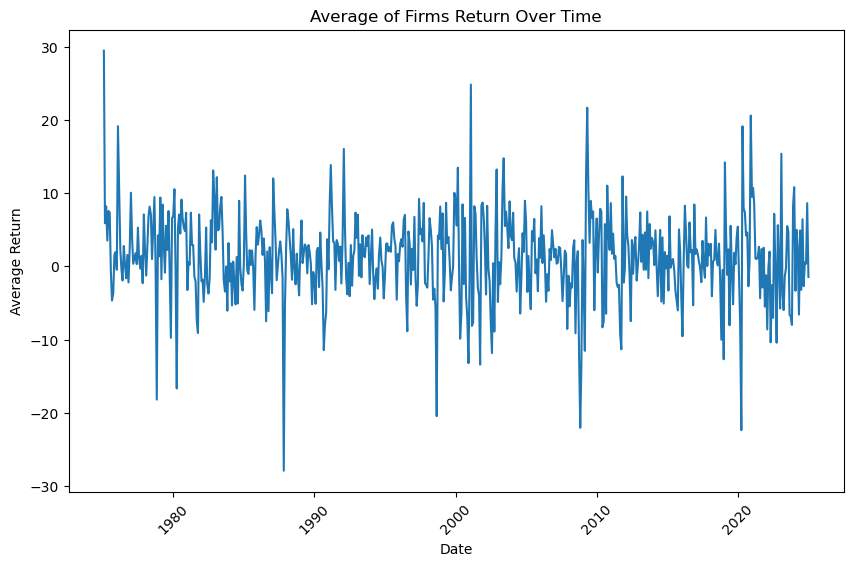

In [6]:
# Exploratory Data Analysis (EDA) on the returns data looking at the average market return per year
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleancrsp, x='date', y='ret', ci=None)
plt.title('Average of Firms Return Over Time')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.xticks(rotation=45)
plt.show()


In [7]:
cleancrsp['ret'].describe(percentiles=[.01, .05, .10, .25, .5, .75, .9, .95, .99, .995]) # check the distribution of returns

count    3.231490e+06
mean     1.244541e+00
std      1.965930e+01
min     -9.956900e+01
1%      -4.098360e+01
5%      -2.333374e+01
10%     -1.606430e+01
25%     -6.843300e+00
50%      0.000000e+00
75%      7.367575e+00
90%      1.785710e+01
95%      2.765960e+01
99%      6.111110e+01
99.5%    8.216832e+01
max      3.900000e+03
Name: ret, dtype: float64

In [8]:
# cleancrsp['permno'].nunique() # check the number of unique permnos

# cleancrsp['permno'].value_counts()


# profile = ProfileReport(cleancrsp, title="CRSP Data Profiling Report")


## Insert FamaFrench Datasets

In [8]:
import pandas_datareader as pdr
# load Fama-French factors

start = '1957-03-01' # start date for Fama-French data based on the s&p500 inception date
start_date = datetime.strptime(start, '%Y-%m-%d')

# load Fama-French 5 factors
ff_5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date)[0]
ff_mom = pdr.get_data_famafrench('F-F_Momentum_Factor', start=start_date)[0]

# # load Fama-French factors
# df_factors = pdr.ff.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', start='1975-01-01').read()[0]

# # add momentum to this

ff_mom.columns = ['Mom'] # rename
ff_mom
ff_factors = pd.merge(ff_5, ff_mom, left_index=True, right_index=True)
# df_factors # FYI: contains Mkt-RF and RF, but no Mkt
#


In [9]:
ff_factors = ff_factors.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})

ff_factors
ff_factors["date"] = ff_factors["date"].dt.to_timestamp()

ff_factors["date"] = ff_factors["date"].apply(lambda x: x.replace(day=28))

# # # Then add the month offset
ff_factors["date"] = ff_factors["date"] + pd.DateOffset(months=1)

ff_factors
## will need to lag the signals and put the date to 28

,date,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,1963-08-28,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1,1963-09-28,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
2,1963-10-28,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
3,1963-11-28,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
4,1963-12-28,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74
...,...,...,...,...,...,...,...,...
733,2024-09-28,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
734,2024-10-28,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
735,2024-11-28,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87
736,2024-12-28,6.51,4.78,-0.05,-2.62,-2.17,0.40,0.90


# Download Zip File from Google Drive

In [11]:
import gdown
if not os.path.exists('signals_wide.zip'):
    # Download the file from Google Drive using gdown
    # Make sure to replace 'FILE_ID' with the actual file ID from your shareable link
    # Example: https://drive.google.com/file/d/FILE_ID/view?usp=sharing
# From a shareable link like: https://drive.google.com/file/d/FILE_ID/view?usp=sharing
    file_id = '1T-nogu88A4hcFXijjftSO41K5P4Hj27y'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'signals_wide.zip'
    gdown.download(url, output, quiet=False)
    
else:
    print("signals_wide.zip already exists. Skipping download.")

signals_wide.zip already exists. Skipping download.


## Open Signals from Zip

In [12]:
from zipfile import ZipFile


def open_dataframe_from_zip(zip_filepath, csv_filename):
    """
    Opens a Pandas DataFrame from a CSV file within a zip archive.

    Args:
        zip_filepath (str): Path to the zip file.
        csv_filename (str): Name of the CSV file inside the zip archive.

    Returns:
        pandas.DataFrame: The DataFrame read from the CSV file, or None if an error occurs.
    """
    try:
        with ZipFile(zip_filepath) as zf:
            with zf.open(csv_filename) as csvf:
                df = pd.read_csv(csvf)
        return df
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_filepath}'")
        return None
    except KeyError:
        print(f"Error: CSV file '{csv_filename}' not found in the zip archive.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage:
if DEV == False:
    zip_filepath = 'signals_wide.zip'
    csv_filename = 'signed_predictors_dl_wide.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename)


    
# for speedy dev,
if DEV: 
    zip_filepath = 'signals.zip'
    csv_filename = 'signals.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename) 
    try:
        signals.drop(columns=['Unnamed: 0'], axis=1, inplace=True) 
    except:
        pass
    try:
        signals.drop(columns=['Unnamed: 0.1'], axis=1, inplace=True)
    except:
        pass

if signals is not None:
    print(signals.head())

   permno  yyyymm  AM  AOP  AbnormalAccruals  Accruals  AccrualsBM  Activism1  \
0   10000  198601 NaN  NaN               NaN       NaN         NaN        NaN   
1   10000  198602 NaN  NaN               NaN       NaN         NaN        NaN   
2   10000  198603 NaN  NaN               NaN       NaN         NaN        NaN   
3   10000  198604 NaN  NaN               NaN       NaN         NaN        NaN   
4   10000  198605 NaN  NaN               NaN       NaN         NaN        NaN   

   Activism2  AdExp  ...  retConglomerate  roaq  sfe  sinAlgo  skew1  \
0        NaN    NaN  ...              NaN   NaN  NaN      NaN    NaN   
1        NaN    NaN  ...              NaN   NaN  NaN      NaN    NaN   
2        NaN    NaN  ...              NaN   NaN  NaN      NaN    NaN   
3        NaN    NaN  ...              NaN   NaN  NaN      NaN    NaN   
4        NaN    NaN  ...              NaN   NaN  NaN      NaN    NaN   

   std_turn  tang  zerotrade12M   zerotrade1M  zerotrade6M  
0       NaN   NaN  

In [13]:
signals.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273600 entries, 0 to 5273599
Columns: 211 entries, permno to zerotrade6M
dtypes: float64(209), int64(2)
memory usage: 8.3 GB


In [15]:
## Repackage the small sample to a zip to create a new zip file for the small sample to reduce time to load --> only do this once
if not os.path.exists('signals.zip') and DEV == True:
    signals.to_csv('signals.csv', index=False)  # Save the DataFrame to a CSV file
    with ZipFile('signals.zip', 'w') as zf:
        zf.write('signals.csv')  # Add the CSV file to the zip archive
    print("signals.zip created with signals.csv inside.")

else:
    print("signals.zip already exists. Skipping creation.")

signals.zip already exists. Skipping creation.


In [16]:
# function to move columns to the fropnt fo a dataframe
def move_column_to_front(df, columns):
    return df[columns + [col for col in df.columns if col not in columns]]  


In [17]:
# rename yyyymm to signals so we avoid confusion
signals = signals.rename(columns={'yyyymm': 'yyyymm_signals'})


    # Create date that is one month ahead for merging with returns
signals["yyyymm_signals"] = signals["yyyymm_signals"].astype(str) 
signals["date"] = pd.to_datetime(signals["yyyymm_signals"] + "28", format="%Y%m%d") + pd.DateOffset(months=1)




In [18]:
signals = move_column_to_front(signals, ['permno', 'date']) # lag signals by a month

signals.head()

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
0,10000,1986-02-28,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,10000,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,10000,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,10000,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN


In [19]:
# create a new datetime column, use the year and month, but make the date 28th of the month:
cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_55051/411256695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


## Need to Convert yyyymm column to yyyy-mm-dd datetime column, rename to date

Something interesting, the crsp dataset uses trading days. How do we get this in our signals dataset. Just go off year-months?

Can we merge on yyyy-mm and not include dd so that we can match the crsp dates? But how would it know the date in the future? For instance, would it know the end of the month a year from now, or guess based on the previous crsp dd for that year or month before?

Is lagging the signals the right thing to do or do I lag the returns??


value weighting 


## Merge all of the Datasets together

In [20]:
smalldata = cleancrsp.merge(signals, on=['permno', 'date'], how='left', validate="one_to_one") 
smalldata 

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
0,10000,1986-02-28,-25.7143,198601,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-28,36.5385,198602,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,10000,1986-04-28,-9.8592,198603,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,10000,1986-05-28,-22.2656,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,10000,1986-06-28,-0.5025,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231485,93436,2024-08-28,-7.7391,202407,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
3231486,93436,2024-09-28,22.1942,202408,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
3231487,93436,2024-10-28,-4.5025,202409,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
3231488,93436,2024-11-28,38.1469,202410,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN


In [21]:
bigdata = smalldata.merge(ff_factors, on='date', how='left', validate="many_to_one") # merge with Fama-French factors
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,zerotrade12M,zerotrade1M,zerotrade6M,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10000,1986-02-28,-25.7143,198601,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.65,1.01,0.44,-2.00,-2.03,0.56,3.00
1,10000,1986-03-28,36.5385,198602,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.785175e-08,NaN,7.13,-0.71,-0.72,1.06,-1.20,0.53,2.76
2,10000,1986-04-28,-9.8592,198603,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.023392e-07,NaN,4.88,-0.66,-0.39,1.21,0.92,0.60,2.41
3,10000,1986-05-28,-22.2656,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.467463e-08,NaN,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
4,10000,1986-06-28,-0.5025,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.649551e-08,NaN,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231485,93436,2024-08-28,-7.7391,202407,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,1.24,8.28,5.74,0.22,0.43,0.45,-2.42
3231486,93436,2024-09-28,22.1942,202408,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
3231487,93436,2024-10-28,-4.5025,202409,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
3231488,93436,2024-11-28,38.1469,202410,NaN,NaN,-0.071498,0.043799,NaN,NaN,...,NaN,NaN,NaN,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87


In [22]:
# Create a list of signal columns to describe

signal_list = bigdata.columns[4:] 


# Open Documentation to Accurately Map Dtypes

In [23]:
# pretend its a dataframe grab the rows where the column is the name and make that a list

signal_documentation = pd.read_csv('SignalDoc.csv')
signal_documentation

# need to find a way to add the column type from cat. form to match the acronyms which are the columns of the dataset
signaldoc = signal_documentation[['Acronym', 'Cat.Form']].drop_duplicates()
signaldoc


,Acronym,Cat.Form
0,AbnormalAccruals,continuous
1,Accruals,continuous
2,AccrualsBM,discrete
3,Activism1,continuous
4,AM,continuous
...,...,...
326,SP_q,continuous
327,tang_q,continuous
328,Tax_q,continuous
329,WW_Q,continuous


# Import Packages

In [13]:

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score


In [25]:
## First We need to split the data into train and test sets
## Don't use train, test, split

X = bigdata.drop(columns=['ret']) # drop the columns that are not needed
y = bigdata['ret'] # target variable
y_permno = bigdata[['permno', 'ret']] # permno for later use



## Convert to Float32 for better run times

In [26]:

float_cols = X.select_dtypes('float64').columns
X.loc[:, float_cols] = X.loc[:, float_cols].astype(np.float32, copy=False)

X.info()

y= y.astype(np.float32)
y_permno = y_permno.astype(np.float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231490 entries, 0 to 3231489
Columns: 219 entries, permno to Mom
dtypes: datetime64[ns](1), float64(216), int64(1), object(1)
memory usage: 5.3+ GB


In [ ]:
X['NOA'].describe() # use NOA to grab top firms as this is best variable in terms of firm size

count    2.463182e+06
mean    -5.576470e-01
std      1.424970e+00
min     -5.120953e+02
25%     -7.489496e-01
50%     -5.769433e-01
75%     -3.000355e-01
max      4.981454e+02
Name: NOA, dtype: float64

In [30]:
DEV2 = True

if DEV2 == True:
    # for speedy dev, pick the top 1000 permnos by NOA -- best signal I could get 
    # Step 1: Filter to year 2021
    X['year'] = X['date'].dt.year
    df_2020 = X[(X['year'] == 2020) & (X['NOA'].notnull())]
    

# Step 2: Get average NOA per permno in 2020
    top_firms = (
        df_2020.groupby('permno')['NOA']
        .mean()
        .sort_values(ascending=False)
        .head(5000)
        .index 
    )

# Step 3: Filter the full dataset to only these top 1000 firms
    X_top5000 = X[X['permno'].isin(top_firms)]
    y_top5000 = y_permno[y_permno['permno'].isin(top_firms)]
    

    


In [66]:
if not os.path.exists('X_top5000.csv') and DEV2 == True:
    X_top5000.to_csv('X_top5000.csv', index=False)
    y_top5000.to_csv('y_top5000.csv', index=False)
    print("X_top5000.csv and y_top5000.csv created.")
else: 
    print("X_top5000.csv and y_top5000.csv already exist. Skipping creation.")

X_top5000.csv and y_top5000.csv created.


In [ ]:
X_top5000

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,zerotrade1M,zerotrade6M,mkt_excess,SMB,HML,RMW,CMA,RF,Mom,year
2975,10026,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.13,-0.71,-0.72,1.06,-1.20,0.53,2.76,1986
2976,10026,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.397064e-09,NaN,4.88,-0.66,-0.39,1.21,0.92,0.60,2.41,1986
2977,10026,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.513012e-08,NaN,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37,1986
2978,10026,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.799911e-08,NaN,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05,1986
2979,10026,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.338338e-08,NaN,1.03,-0.89,1.28,1.80,0.87,0.52,5.07,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231485,93436,2024-08-28,202407,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,1.24,8.28,5.74,0.22,0.43,0.45,-2.42,2024
3231486,93436,2024-09-28,202408,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79,2024
3231487,93436,2024-10-28,202409,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60,2024
3231488,93436,2024-11-28,202410,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87,2024


In [33]:
y_top5000 = y_top5000['ret']

### Train/Validate and Test Split

In [34]:
# Split the data into train and test sets based on date

holdout_date = '2020-12-28'  # Define the split date
if DEV2 == False:
    X_train = X[X['date'] <= holdout_date]
    X_test = X[(X['date'] >  holdout_date)]
    y_train = y[X['date'] <= holdout_date]
    y_test = y[(X['date'] >  holdout_date)]
    
else:
    X_train = X_top5000[X_top5000['date'] <= holdout_date]
    X_test = X_top5000[(X_top5000['date'] >  holdout_date)]
    y_train = y_top5000[X_top5000['date'] <= holdout_date]
    y_test = y_top5000[(X_top5000['date'] >  holdout_date)]

## More EDA on the train data

In [36]:
X_train

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,zerotrade1M,zerotrade6M,mkt_excess,SMB,HML,RMW,CMA,RF,Mom,year
2975,10026,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.13,-0.71,-0.72,1.06,-1.20,0.53,2.76,1986
2976,10026,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.397064e-09,NaN,4.88,-0.66,-0.39,1.21,0.92,0.60,2.41,1986
2977,10026,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.513012e-08,NaN,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37,1986
2978,10026,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.799911e-08,NaN,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05,1986
2979,10026,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.338338e-08,NaN,1.03,-0.89,1.28,1.80,0.87,0.52,5.07,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231437,93436,2020-08-28,202007,0.128672,-15.579787,0.059332,0.059896,NaN,NaN,NaN,...,1.444940e-09,7.621905e-09,5.77,-3.18,-1.44,0.40,1.03,0.01,7.59,2020
3231438,93436,2020-09-28,202008,0.073888,-15.579787,0.059332,0.059896,NaN,NaN,NaN,...,9.801464e-10,7.702409e-09,7.63,-0.95,-2.88,4.33,-1.26,0.01,0.44,2020
3231439,93436,2020-10-28,202009,0.084359,-15.579787,0.059332,0.059896,NaN,NaN,NaN,...,1.249744e-09,8.225926e-09,-3.63,-0.05,-2.65,-1.28,-1.96,0.01,3.14,2020
3231440,93436,2020-11-28,202010,0.093276,-15.579787,0.059332,0.059896,NaN,NaN,NaN,...,1.122430e-09,8.627871e-09,-2.10,4.54,4.31,-0.76,-0.88,0.01,-3.20,2020


In [35]:
y_train

2975       13.333300
2976        7.058800
2977       40.659302
2978      -15.625000
2979      -37.500000
             ...    
3231437    74.145203
3231438   -13.908700
3231439    -9.549900
3231440    46.273602
3231441    24.325199
Name: ret, Length: 860760, dtype: float32

Text(0.5, 1.0, 'Number of Firms by Year in the Data')

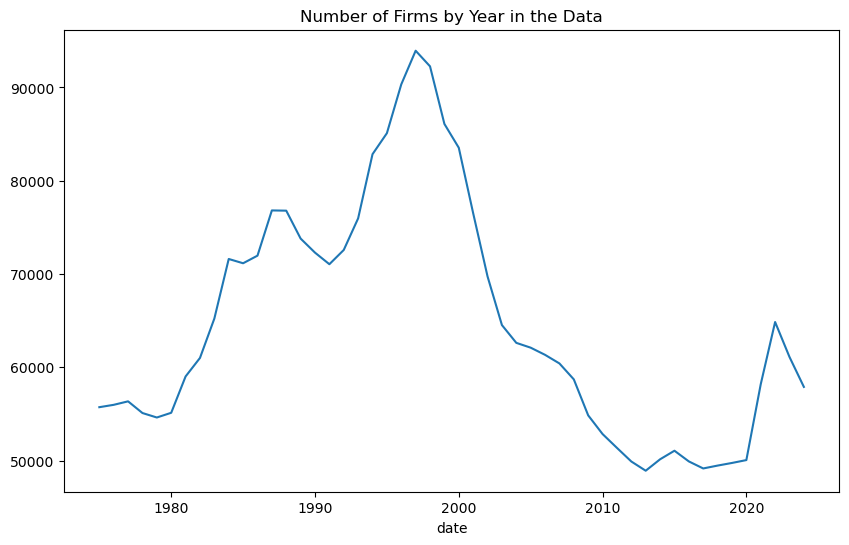

In [37]:
# Firms by year
X['date'].dt.year.value_counts().sort_index().plot(kind='line', figsize=(10, 6)).set_title('Number of Firms by Year in the Data')

##  Training preliminaries

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin


class CrossSectionalMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute=None):
        
        self.features_to_impute = features_to_impute 

    def fit(self, X, y=None):
        # Nothing to fit — this imputer calculates means on the fly
        return self
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []

    def transform(self, X):
        X = X.copy()
        
        # Make sure it's a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CrossSectionalMeanImputer only works on pandas DataFrames")
        
        # Check if index is a MultiIndex with 'date' as one of the levels
        if not isinstance(X.index, pd.MultiIndex) or 'date' not in X.index.names:
            raise ValueError("Input DataFrame must have a MultiIndex with 'date' as one of the levels")
    
        
        # Create a year variable
        X['_year'] = pd.to_datetime(X.index.get_level_values('date')).year.values
        
        # For each numeric column, fill NaNs with cross-sectional mean within each year
        # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        if self.features_to_impute is not None:
            cols_to_impute = [col for col in self.features_to_impute if col in X.columns]
        else:
            cols_to_impute = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        for col in cols_to_impute:
            col_global_mean = X[col].mean()
            
            # If the global mean itself is NaN, fallback to 0
            if pd.isna(col_global_mean):
                col_global_mean = 0.0
            
            def safe_fill(x):
                if x.isnull().all():
                    return x.fillna(col_global_mean)  # use fallback global mean (guaranteed non-NaN now)
                else:
                    return x.fillna(x.mean())  # cross-sectional mean
                
            X[col] = X.groupby('_year')[col].transform(safe_fill)
            
        X = X.drop(columns=['_year'])
        
        return X
        

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.0025, upper=0.9975):
        self.lower = lower
        self.upper = upper
    
    def fit(self, X, y=None):
        # Store quantiles for each column
        X_df = pd.DataFrame(X)
        self.lower_bounds_ = X_df.quantile(self.lower)
        self.upper_bounds_ = X_df.quantile(self.upper)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        for col in X_df.columns:
            X_df[col] = X_df[col].clip(lower=self.lower_bounds_[col],
                                       upper=self.upper_bounds_[col])
        return X_df.values  # return as numpy array for sklearn compatibility
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []


In [40]:
from sklearn.linear_model import RidgeCV

# Set the index of X to permno and date

exclude = ['ret', 'yyyymm_signals', 'permno', '_merge'] # columns to exclude from the preprocessing pipe

continuous_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'continuous', 'Acronym'].tolist() + ['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'Mom'] # convert df to list to get columns for preprocessing pipe
# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom' are the Five Fama-French factors and momentum factor
discrete_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'discrete', 'Acronym'].tolist() # convert df to list to get columns for preprocessing pipe



continuous_cols = [col for col in continuous_cols if col in X.columns and col not in exclude] # filter out columns that are not in X
discrete_cols = [col for col in discrete_cols if col in X.columns and col not in exclude] # filter out columns that are not in X

numer_pipe = make_pipeline(CrossSectionalMeanImputer(features_to_impute=continuous_cols), Winsorizer(lower=0.0025, upper=0.9975),
                           StandardScaler()) # use CrossSectionalMeanImputer to fill NaNs with cross-sectional mean within each year, then standardize the data and winsorize it

# cat_pipe   = make_pipeline(CrossSectionalModeImputer(features_to_impute=discrete_cols), OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # drop first to avoid dummy variable trap
cat_pipe   = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # drop first to avoid dummy variable trap


preproc_pipe = ColumnTransformer(
    transformers=[
        ('numbers', numer_pipe, continuous_cols),  
        ('categoricals', cat_pipe, discrete_cols), 
    ],
    remainder='drop'  
)



# from df_after_transform import df_after_transform

# if X_train.index.nlevels != 2 or 'date' not in X_train.index.names:
#     X_train = X_train.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
# else:
#     X_train = X_train.copy()
# # make sure the index is a MultiIndex with permno and date

# preproc_df = df_after_transform(preproc_pipe,X_train) #only fill on the training set --> data leakage could be introduced if we fill on the entire dataset
# preproc_df
# print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
# preproc_df.describe().T.round(2)
# model_pipe.fit(,



In [ ]:
# preproc_df.describe(percentiles= [.0025, .01, .05, .25, .5, .75, .95, .99, .9975]).T.round(2)

,count,mean,std,min,0.2%,1%,5%,25%,50%,75%,95%,99%,99.8%,max
AbnormalAccruals,860760.0,0.00,1.00,-14.98,-4.19,-2.43,-1.11,-0.26,-0.01,0.18,1.11,2.92,5.94,62.24
Accruals,860760.0,0.00,1.00,-32.71,-4.37,-2.61,-1.22,-0.31,-0.01,0.31,1.18,2.61,4.74,61.20
Activism1,860760.0,-0.00,1.00,-14.67,-7.91,-2.83,-0.59,-0.00,-0.00,-0.00,0.51,3.94,7.32,14.09
AM,860760.0,-0.00,1.00,-0.32,-0.32,-0.31,-0.30,-0.26,-0.18,-0.01,0.76,2.36,5.59,182.82
AnalystRevision,860760.0,0.00,1.00,-462.87,-1.38,-0.40,-0.07,-0.01,-0.00,0.00,0.07,0.37,1.58,343.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sinAlgo_1.0,860760.0,0.01,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
Spinoff_0.0,860760.0,0.97,0.16,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Spinoff_1.0,860760.0,0.03,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
UpRecomm_0.0,860760.0,0.91,0.28,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [15]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),  # 3 layers: 256 → 128 → 64 nodes does best with 3 hidden layers, should I reduce or increase the nodes?
    activation='relu',
    solver='adam',
    alpha=1e-6,            # L2 penalty (like weight decay)
    batch_size=512,
    learning_rate='adaptive',  # lowers learning rate when no improvement
    learning_rate_init=0.0001,
    max_iter=100,
    early_stopping=True,   # Very important to avoid overfitting
    validation_fraction=0.1,  # 10% of training data used for validation internally
    random_state=42,
    # verbose=True           # See training progress
)

In [42]:
X_train.set_index(['permno', 'date'], inplace=True) # set the index to permno and date for cross-sectional mean imputer

In [43]:
X_train.shape

(860760, 218)

## Main training loop

In [68]:
######## START: PARAMETERS #########

prediction_output_fname = 'predictions/prediction_output3.csv'
force_rerun = False # set to True to force run all models again
    
# Create a Loop that goes by year instead of doing cv split function, trains up to year, validates and then expands trains and validates continued until end of training
model_dict = { 
               'Lasso': Lasso(),
               'Ridge': Ridge(), 
               'hgbr': HistGradientBoostingRegressor(),
               'mlp': mlp,
              }

# Create a dictionary to store the parameters for the mlp regressor (hidden layer sizes from 1 to 5)
params = {
    'mlp': { 'hidden_layer_sizes' : [(64, 32)]#, (128, 64, 32), (256, 128, 64, 32)] #, #(256, 128, 64, 32), (512, 256, 128, 64, 32)],
}}

######## END: PARAMETERS #########

os.makedirs(os.path.dirname(prediction_output_fname), exist_ok=True)
if os.path.exists(prediction_output_fname):
    prediction_output = pd.read_csv(prediction_output_fname)
    prediction_output['date'] = pd.to_datetime(prediction_output['date'])
    already_run_models = [c[5:] for c in prediction_output.columns if c.startswith('pred_')]
else:
    already_run_models = []
results = {}

for model in model_dict.keys():
    print(f"\nTraining model: {model}")
    param_grid = params.get(model, {})
    for param in ParameterGrid(param_grid):
  # Get parameters for the model or an empty dict if none
        print(f"Using parameters: {param}")
        if model == 'mlp':
                # Assume param is a dictionary like {'hidden_layer_sizes': (64, 32)}
                param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
                model_name = f"{model}_{param_suffix}"
        else:
                model_name = model  # Ridge, RF, etc, no param differentiation
                
        if model_name in already_run_models and not force_rerun:
            print(f"Model {model_name} already run. Skipping.")
            continue
                
        if model_name not in results:
            results[model_name] = []  # Initialize results for this model variant

        # Train and validate for each year
   
        for year in tqdm(range(2000, 2020), desc="Training Years", unit="year"):
            # print(f"Training to predict year: {year}")
            
            # Split the data into train and test sets based on year
            X_train_year = X_train[X_train.index.get_level_values('date').year < year]
            y_train_year = y_train[X_train.index.get_level_values('date').year < year]
            
            X_val_year = X_train[X_train.index.get_level_values('date').year == year]
            y_val_year = y_train[X_train.index.get_level_values('date').year == year]
            
            # Fit the model
            model_pipe = make_pipeline(preproc_pipe, model_dict[model].set_params(**param))
            model_pipe.fit(X_train_year, y_train_year)
            
            y_pred = model_pipe.predict(X_val_year) 
            
            # Validate the model
            
            
            # Make predictions
            
            # Make a nice model name
            
            results[model_name].append(pd.DataFrame({
                'permno': X_val_year.index.get_level_values('permno'),
                'date': X_val_year.index.get_level_values('date'),
                'ret': y_val_year.values,
                f'pred_{model_name}': y_pred,
    
            }))
            # combine into a dataframe
         
if len(results) > 0:            
    # Concatenate and save the results:

    model_dfs = {
        model: pd.concat(df_list, ignore_index=True)
        for model, df_list in results.items()
    }

    from functools import reduce

    # List of all model prediction DataFrames
    dfs = list(model_dfs.values())

    # Merge all on ['permno', 'date', 'ret']
    results_df = reduce(
        lambda left, right: pd.merge(left, right, on=['permno', 'date', 'ret'], how='outer'),
        dfs
    )

    bigresults = results_df.drop_duplicates(subset=['permno', 'date'], keep='first')  # Keep the last occurrence of each permno-date pair
    bigresults = bigresults.sort_values(by=['date','permno']).reset_index(drop=True)  # Sort by permno and date

    # combine with already existing predictions
    if os.path.exists(prediction_output_fname):
        bigresults = pd.merge(bigresults, 
                            prediction_output, 
                            on=['permno', 'date'], how='outer', validate="one_to_one")

        # for any pair of columns with _x and _y, combine them (put ret_y where ret_x is null, rename ret_x, delete ret_y)
        col_pairs = [(col, col.replace('_x', '_y')) for col in bigresults.columns if '_x' in col and col.replace('_x', '_y') in bigresults.columns]
        for col_x, col_y in col_pairs:
            bigresults[col_x] = bigresults[col_x].combine_first(bigresults[col_y])
            bigresults.drop(columns=[col_y], inplace=True)
            bigresults.rename(columns={col_x: col_x.replace('_x', '')}, inplace=True)
        
    bigresults = move_column_to_front(bigresults, ['permno', 'date', 'ret'])

    bigresults.to_csv(prediction_output_fname, index=False)  # Save the results to a CSV file
    display(bigresults)



Training model: Lasso
Using parameters: {}
Model Lasso already run. Skipping.

Training model: Ridge
Using parameters: {}
Model Ridge already run. Skipping.

Training model: hgbr
Using parameters: {}
Model hgbr already run. Skipping.

Training model: mlp
Using parameters: {'hidden_layer_sizes': (64, 32)}


Training Years:  15%|█▌        | 3/20 [05:23<31:52, 112.52s/year]/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Years: 100%|██████████| 20/20 [1:10:48<00:00, 212.45s/year]


,permno,date,ret,pred_mlp_64_32,pred_hgbr,pred_Ridge,pred_Lasso
0,10026,2000-01-28,-6.707300,-3.087303,-1.168474,1.828436,1.318497
1,10026,2000-02-28,-3.594800,-6.181767,-0.754493,-2.383935,0.538816
2,10026,2000-03-28,7.796600,0.345857,1.356252,1.146310,1.394694
3,10026,2000-04-28,-19.811300,6.892393,4.891007,6.449942,2.720516
4,10026,2000-05-28,-6.666700,6.011822,5.384457,1.469390,1.354735
...,...,...,...,...,...,...,...
577361,93436,2019-08-28,-6.622200,-12.534226,0.631447,-5.319272,1.315368
577362,93436,2019-09-28,6.763900,-10.452514,-0.123594,-5.617228,1.315368
577363,93436,2019-10-28,30.742701,-0.750404,-0.759560,-4.837613,1.315368
577364,93436,2019-11-28,4.769500,-6.445116,0.296685,-4.592998,1.315368


In [11]:
######## START: PARAMETERS #########

prediction_output_fname = 'predictions/prediction_output3.csv'
force_rerun = False # set to True to force run all models again
    
# Create a Loop that goes by year instead of doing cv split function, trains up to year, validates and then expands trains and validates continued until end of training
model_dict = { 
               'Lasso': Lasso(),
               'Ridge': Ridge(), 
               'hgbr': HistGradientBoostingRegressor(),
               'mlp': mlp,
              }

# Create a dictionary to store the parameters for the mlp regressor (hidden layer sizes from 1 to 5)
params = {
    'mlp': { 'hidden_layer_sizes' : [(64, 32), (128, 64, 32), (256, 128, 64, 32)] #, #(256, 128, 64, 32), (512, 256, 128, 64, 32)],
}}

######## END: PARAMETERS #########

os.makedirs(os.path.dirname(prediction_output_fname), exist_ok=True)
if os.path.exists(prediction_output_fname):
    prediction_output = pd.read_csv(prediction_output_fname)
    prediction_output['date'] = pd.to_datetime(prediction_output['date'])
    already_run_models = [c[5:] for c in prediction_output.columns if c.startswith('pred_')]
else:
    already_run_models = []
results = {}

for model in model_dict.keys():
    print(f"\nTraining model: {model}")
    param_grid = params.get(model, {})
    for param in ParameterGrid(param_grid):
  # Get parameters for the model or an empty dict if none
        print(f"Using parameters: {param}")
        if model == 'mlp':
                # Assume param is a dictionary like {'hidden_layer_sizes': (64, 32)}
                param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
                model_name = f"{model}_{param_suffix}"
        else:
                model_name = model  # Ridge, RF, etc, no param differentiation
                
        if model_name in already_run_models and not force_rerun:
            print(f"Model {model_name} already run. Skipping.")
            continue
                
        if model_name not in results:
            results[model_name] = []  # Initialize results for this model variant

        # Train and validate for each year
   
        for year in tqdm(range(2000, 2020), desc="Training Years", unit="year"):
            # print(f"Training to predict year: {year}")
            
            # Split the data into train and test sets based on year
            X_train_year = X_train[X_train.index.get_level_values('date').year < year]
            y_train_year = y_train[X_train.index.get_level_values('date').year < year]
            
            X_val_year = X_train[X_train.index.get_level_values('date').year == year]
            y_val_year = y_train[X_train.index.get_level_values('date').year == year]
            
            # Fit the model
            model_pipe = make_pipeline(preproc_pipe, model_dict[model].set_params(**param))
            model_pipe.fit(X_train_year, y_train_year)
            
            y_pred = model_pipe.predict(X_val_year) 
            
            # Validate the model
            
            
            # Make predictions
            
            # Make a nice model name
            
            results[model_name].append(pd.DataFrame({
                'permno': X_val_year.index.get_level_values('permno'),
                'date': X_val_year.index.get_level_values('date'),
                'ret': y_val_year.values,
                f'pred_{model_name}': y_pred,
    
            }))
            # combine into a dataframe
         
if len(results) > 0:            
    # Concatenate and save the results:

    model_dfs = {
        model: pd.concat(df_list, ignore_index=True)
        for model, df_list in results.items()
    }

    from functools import reduce

    # List of all model prediction DataFrames
    dfs = list(model_dfs.values())

    # Merge all on ['permno', 'date', 'ret']
    results_df = reduce(
        lambda left, right: pd.merge(left, right, on=['permno', 'date', 'ret'], how='outer'),
        dfs
    )

    bigresults = results_df.drop_duplicates(subset=['permno', 'date'], keep='first')  # Keep the last occurrence of each permno-date pair
    bigresults = bigresults.sort_values(by=['date','permno']).reset_index(drop=True)  # Sort by permno and date

    # combine with already existing predictions
    if os.path.exists(prediction_output_fname):
        bigresults = pd.merge(bigresults, 
                            prediction_output, 
                            on=['permno', 'date'], how='outer', validate="one_to_one")

        # for any pair of columns with _x and _y, combine them (put ret_y where ret_x is null, rename ret_x, delete ret_y)
        col_pairs = [(col, col.replace('_x', '_y')) for col in bigresults.columns if '_x' in col and col.replace('_x', '_y') in bigresults.columns]
        for col_x, col_y in col_pairs:
            bigresults[col_x] = bigresults[col_x].combine_first(bigresults[col_y])
            bigresults.drop(columns=[col_y], inplace=True)
            bigresults.rename(columns={col_x: col_x.replace('_x', '')}, inplace=True)
        
    bigresults = move_column_to_front(bigresults, ['permno', 'date', 'ret'])

    bigresults.to_csv(prediction_output_fname, index=False)  # Save the results to a CSV file
    display(bigresults)


NameError: name 'Lasso' is not defined

In [70]:
bigresults.filter(like='pred').describe().round(2) 

,pred_mlp_128_64_32,pred_mlp_256_128_64_32,pred_mlp_64_32,pred_hgbr,pred_Ridge,pred_Lasso
count,577366.00,577366.00,577366.00,577366.00,577366.00,577366.00
mean,0.73,0.17,-0.78,1.45,0.06,1.58
std,6.26,5.80,6.77,3.50,2.82,0.47
min,-47.78,-54.26,-68.43,-16.96,-15.26,-1.61
25%,-2.20,-2.47,-4.39,-0.23,-1.80,1.39
50%,0.76,0.40,-0.74,1.20,-0.22,1.57
75%,3.53,2.74,2.42,2.57,1.57,1.79
max,93.93,94.81,83.42,110.61,37.90,4.78


In [ ]:
# want to see the predictor signals in the year 2001 from x_train


,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,zerotrade1M,zerotrade6M,mkt_excess,SMB,HML,RMW,CMA,RF,Mom,year
count,18892.000000,10409.000000,15387.000000,17633.000000,1173.000000,2589.000000,756.000000,5370.000000,1632.000000,14846.000000,...,1.984700e+04,1.957900e+04,19905.000000,19905.000000,19905.000000,19905.000000,19905.000000,19905.000000,19905.000000,19905.0
mean,2.803019,-1.904232,-0.006448,0.026328,0.334186,14.640015,8.175410,0.054480,17.787377,0.968578,...,9.502780e-01,5.587869e+00,-1.172635,1.853065,1.863104,1.497903,1.375299,0.341727,0.221736,2001.0
std,6.161493,12.408411,0.229907,0.093808,0.471906,2.708001,9.042245,0.188945,21.874639,1.154805,...,2.755447e+00,1.536336e+01,5.850746,3.487168,5.547825,4.310879,4.329758,0.103799,10.483247,0.0
min,0.012803,-360.431030,-1.070779,-0.878096,0.000000,8.000000,0.000000,0.000096,1.000000,-83.000000,...,9.914895e-11,3.193492e-09,-10.050000,-5.730000,-7.650000,-4.690000,-5.030000,0.170000,-25.299999,2001.0
25%,0.561653,-0.826326,-0.061949,-0.012725,0.000000,13.000000,0.000000,0.005343,5.000000,0.986014,...,1.646684e-08,1.158199e-07,-6.460000,-0.860000,-1.120000,-2.980000,-1.640000,0.280000,-8.470000,2001.0
50%,1.313524,-0.226890,-0.013114,0.029167,0.000000,15.000000,7.541896,0.014015,10.000000,1.000000,...,3.490003e-08,2.334325e-07,-1.940000,2.720000,2.210000,1.600000,1.910000,0.310000,2.210000,2001.0
75%,3.096911,-0.008335,0.031529,0.065933,1.000000,17.000000,9.706716,0.046838,18.000000,1.000000,...,1.084262e-07,1.000000e+00,2.460000,5.270000,5.210000,4.990000,3.920000,0.390000,6.740000,2001.0
max,266.701630,4.673494,6.907916,0.729151,1.000000,20.000000,52.647388,4.440622,106.000000,41.000000,...,2.008699e+01,1.108800e+02,7.940000,6.570000,12.470000,9.100000,9.070000,0.540000,12.570000,2001.0


Text(0.5, 1.0, 'Number of Firms by Year in the Data')

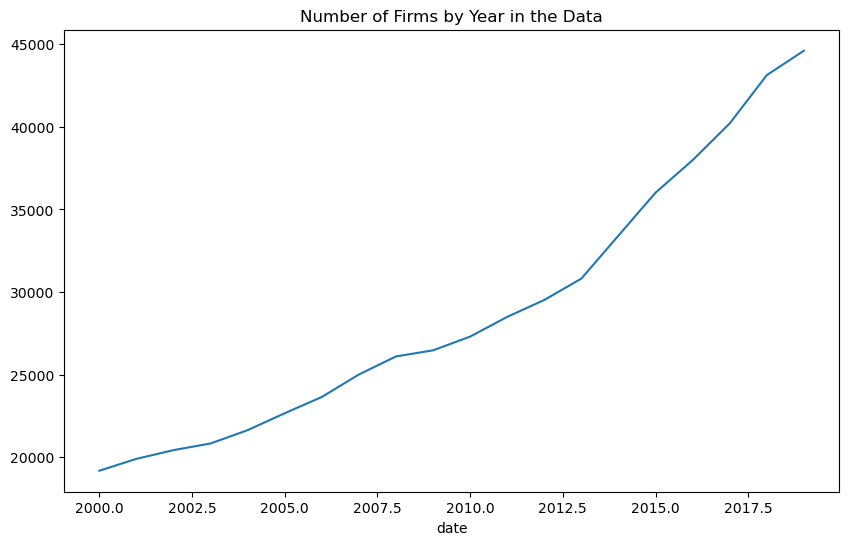

In [ ]:
bigresults['date'].dt.year.value_counts().sort_index().plot(kind='line', figsize=(10, 6)).set_title('Number of Firms by Year in the Data')

In [ ]:
# resultsridge = [] # list to store the results for ridge regression
# for year in tqdm(range(2000, 2010), desc="Training Years", unit="year"):
#             # print(f"Training to predict year: {year}")
            
#             # Split the data into train and test sets based on year
#             X_train_year = X_train[X_train.index.get_level_values('date').year < year]
#             y_train_year = y_train[X_train.index.get_level_values('date').year < year]
            
#             X_val_year = X_train[X_train.index.get_level_values('date').year == year]
#             y_val_year = y_train[X_train.index.get_level_values('date').year == year]
            
#             # Fit the model
#             model_pipe = make_pipeline(preproc_pipe, Ridge())
#             model_pipe.fit(X_train_year, y_train_year)
            
#             y_pred = model_pipe.predict(X_val_year) 
            
#             # store the monthly predictions for all permno months in a dataframe
            
#             df_year = pd.DataFrame({
#             'permno': X_val_year.index.get_level_values('permno'),
#             'date': X_val_year.index.get_level_values('date'),
#             'y_true': y_val_year,
#             'y_pred': y_pred,
#             })
#             df_year['resid'] = df_year['y_pred'] - df_year['y_true']
#             df_year['year'] = year
#             df_year['model'] = 'ridge'

#             resultsridge.append(df_year)
            
#             # Validate the model
            
# results_df_ridge = pd.concat(resultsridge).reset_index(drop=True)


Training Years: 100%|██████████| 10/10 [05:53<00:00, 35.38s/year]


## Make portfolio returns

For a given model (column in the prediction df which are your new signals), compute the portfolio returns by sorting the predictions into quintiles or deciles and computing the average return of each decile.

In [55]:
## get mkt-rf from fama-french factors
mkt_rf = ff_factors[['date', 'mkt_excess']].copy()

# start only in 2000
mkt_rf = mkt_rf[mkt_rf['date'] >= '2000-01-01']
mkt_rf


,date,mkt_excess
437,2000-01-28,7.72
438,2000-02-28,-4.74
439,2000-03-28,2.45
440,2000-04-28,5.20
441,2000-05-28,-6.40
...,...,...
733,2024-09-28,1.61
734,2024-10-28,1.74
735,2024-11-28,-0.97
736,2024-12-28,6.51


In [56]:
mkt_rf['cumret'] = (1 + mkt_rf['mkt_excess']/100).cumprod() - 1

Text(0.5, 1.0, 'Cumulative Market Return (Mkt-RF) Over Time')

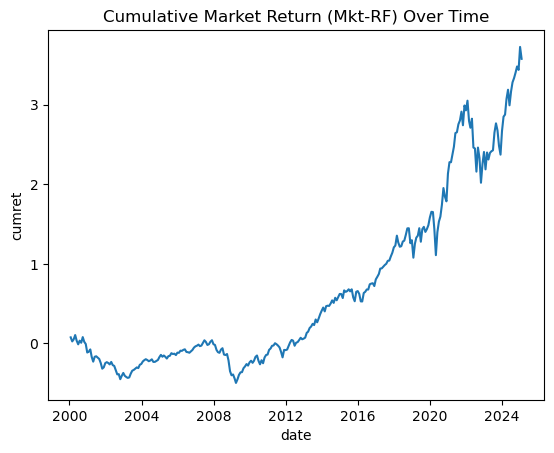

In [ ]:
sns.lineplot(mkt_rf, x='date', y='cumret').set_title('Cumulative Market Return (Mkt-RF) Over Time')

In [ ]:
my_signals = pd.read_csv(prediction_output_fname)



In [27]:
bigresults2 = bigresults.copy()  # Create a copy to avoid modifying the original DataFrame

def port_sort(x, nport):
    return np.ceil(x.rank(method="min") * nport / (len(x) + 1)).astype(int)

def portfolio_create(df, model_dict, params, nport=5, samplength=5):
    results_large = []
    for model in model_dict:
        param_grid = params.get(model, {})
        for param in ParameterGrid(param_grid) or [{}]:  # Handle empty grids
            # Model-specific name handling
            if model == 'mlp':
                param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
                model_name = f"{model}_{param_suffix}"
            else:
                model_name = model  # Ridge, RF, etc

            pred_col = f'pred_{model_name}'  # Match predicted column name
            port_col = f'port_{model_name}'  # Output portfolio column
            ret_col = 'ret'  # Assuming 'ret' is the column for returns

            if pred_col not in df.columns:
                print(f"Skipping {model_name}: {pred_col} not found.")
                continue

            # Assign portfolio rank (1 to 5)
            df[port_col] = df.groupby('date')[pred_col].transform( lambda x:
                # Use port_sort to assign portfolio ranks
                port_sort(x, nport)
            )
            

            portdat = (
                df.groupby([port_col, "date"], observed=False)
                .agg(ret=(ret_col, "mean"), nstock=("permno", "nunique"))
                .reset_index()
            )
            bin_edges = list(range(2000, 2022, samplength))  # Extend upper bound to be safe
            bin_labels = bin_edges[:-1]  # One fewer label than edges
            # Step 3: Subsample bins by year
            portdat["subsamp"] = pd.cut(
                portdat["date"].dt.year,
                bins=bin_edges,
                labels=bin_labels,
            )

            # Step 4: Aggregate portfolio stats within subsamples
            portsum = (
                portdat.groupby([port_col, "subsamp"], observed=False)
                .agg(
                    meanret=("ret", "mean"),
                    vol=("ret", "std"),
                    nmonth=("date", "nunique"),
                    nstock=("nstock", "mean"),
                    datemin=("date", "min"),
                    datemax=("date", "max"),
                )
                .reset_index()
            )

            portsum["meanret"] = round(portsum["meanret"], 2)

            # Step 5: Pivot to wide format for final output
            sumwide = portsum.pivot(index="subsamp", columns=port_col, values="meanret").reset_index()
            sumwide.columns = ["subsamp"] + [f"port_{int(col)}" for col in sumwide.columns[1:]]

            # Step 6: Add high-minus-low portfolio spread
            if f"port_{nport}" in sumwide.columns and "port_1" in sumwide.columns:
                sumwide[f"{nport}_minus_1"] = sumwide[f"port_{nport}"] - sumwide["port_1"]

            # Step 7: Add date ranges and human-readable subsample names
            temp = (
                portsum.groupby("subsamp", observed=False)
                .agg(datemin=("datemin", "min"), datemax=("datemax", "max"))
                .reset_index()
            )

            sumwide = pd.merge(temp, sumwide, on="subsamp", how="left")

            sumwide["subsamp"] = sumwide["subsamp"].map(
                {
                    2000: "dot.com",
                    2005: "housing bubble",
                    2010: "obama",
                    2015: "warriors dominance",
                    2020: "pre-pandemic",
                }
            )
            sumwide["model_name"] = model_name
            
            results_large.append(sumwide)
            
            results_concat = pd.concat(results_large, ignore_index=True)
    
    display(results_concat)

    return results_concat, results_concat.to_csv('predictions/portfolios.csv', index=False)

portfolio_create(bigresults2, model_dict, params, nport=5)



# # Portfolio Analysis

# port_returns = pred_df.groupby(['date', 'quintile'])['true_return'].mean().unstack()

# port_returns['H-L'] = port_returns['High'] - port_returns['Low']
# port_returns['H-L'].plot(figsize=(12, 6), title='Average Realized Return by Quintile')

# cumulative_hl = (1 + port_returns['H-L']/100).cumprod()

# # Plot
# # import matplotlib.pyplot as plt
# # plt.figure(figsize=(10,6))
# # plt.plot(cumulative_hl)
# # plt.title('Cumulative Return of High-Low Portfolio')
# # plt.grid(True)
# # plt.show()


,subsamp,datemin,datemax,port_1,port_2,port_3,port_4,port_5,5_minus_1,model_name
0,dot.com,2001-01-28,2005-12-28,1.31,0.96,2.53,3.91,2.39,1.08,Lasso
1,housing bubble,2006-01-28,2010-12-28,0.64,0.35,0.99,2.12,1.72,1.08,Lasso
2,obama,2011-01-28,2015-12-28,0.61,1.45,0.92,0.51,1.01,0.40,Lasso
3,warriors dominance,2016-01-28,2019-12-28,1.02,1.83,0.48,0.32,0.72,-0.30,Lasso
4,dot.com,2001-01-28,2005-12-28,0.70,1.31,1.64,2.25,3.26,2.56,Ridge
5,housing bubble,2006-01-28,2010-12-28,0.19,0.56,0.75,1.10,2.30,2.11,Ridge
6,obama,2011-01-28,2015-12-28,0.30,0.70,0.84,1.11,1.51,1.21,Ridge
7,warriors dominance,2016-01-28,2019-12-28,0.54,0.95,0.85,0.94,0.97,0.43,Ridge
8,dot.com,2001-01-28,2005-12-28,1.11,1.37,1.68,1.79,3.20,2.09,hgbr
9,housing bubble,2006-01-28,2010-12-28,0.00,0.32,0.83,1.30,2.45,2.45,hgbr


(               subsamp    datemin    datemax  port_1  port_2  port_3  port_4  \
 0              dot.com 2001-01-28 2005-12-28    1.31    0.96    2.53    3.91   
 1       housing bubble 2006-01-28 2010-12-28    0.64    0.35    0.99    2.12   
 2                obama 2011-01-28 2015-12-28    0.61    1.45    0.92    0.51   
 3   warriors dominance 2016-01-28 2019-12-28    1.02    1.83    0.48    0.32   
 4              dot.com 2001-01-28 2005-12-28    0.70    1.31    1.64    2.25   
 5       housing bubble 2006-01-28 2010-12-28    0.19    0.56    0.75    1.10   
 6                obama 2011-01-28 2015-12-28    0.30    0.70    0.84    1.11   
 7   warriors dominance 2016-01-28 2019-12-28    0.54    0.95    0.85    0.94   
 8              dot.com 2001-01-28 2005-12-28    1.11    1.37    1.68    1.79   
 9       housing bubble 2006-01-28 2010-12-28    0.00    0.32    0.83    1.30   
 10               obama 2011-01-28 2015-12-28    0.16    0.84    0.88    1.11   
 11  warriors dominance 2016

In [16]:
# Create a Loop that goes by year instead of doing cv split function, trains up to year, validates and then expands trains and validates continued until end of training
model_dict = { 
               'Lasso': Lasso(),
               'Ridge': Ridge(), 
               'hgbr': HistGradientBoostingRegressor(),
               'mlp': mlp,
              }

# Create a dictionary to store the parameters for the mlp regressor (hidden layer sizes from 1 to 5)
params = {
    'mlp': { 'hidden_layer_sizes' : [(64, 32)]#, (128, 64, 32), (256, 128, 64, 32)] #, #(256, 128, 64, 32), (512, 256, 128, 64, 32)],
}}

def portfolio_create2(df, model_dict, params, nport=5):
    results_large = []
    
    for model in model_dict:
        param_grid = params.get(model, {})
        for param in ParameterGrid(param_grid) or [{}]:  # Handle empty grids
            # Model-specific name handling
            if model == 'mlp':
                param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
                model_name = f"{model}_{param_suffix}"
            else:
                model_name = model

            pred_col = f'pred_{model_name}'
            port_col = f'port_{model_name}'
            ret_col = 'ret'

            if pred_col not in df.columns:
                print(f"Skipping {model_name}: {pred_col} not found.")
                continue

            # Assign portfolio rank (1 to nport)
            # df[port_col] = df.groupby('date')[pred_col].transform(lambda x: port_sort(x, nport))

            df[port_col] = df.groupby('date')[pred_col].transform(lambda x: pd.qcut(x, nport, labels=False, duplicates='drop') + 1)
            # Aggregate returns by portfolio and date
            portdat = (
                df.groupby([port_col, "date"], observed=False)
                .agg(ret=(ret_col, "mean"), nstock=("permno", "nunique"))
                .reset_index()
            )

            # Pivot: one column per portfolio
            portwide = portdat.pivot(index='date', columns=port_col, values='ret')

            # Rename columns for clarity
            portwide.columns = [f'port_{int(col)}' for col in portwide.columns]

            # Compute H-L return (portfolio 5 - portfolio 1)
            portwide['hl'] = portwide.get(f'port_{nport}') - portwide.get('port_1')

            # Compute cumulative returns
            portwide['hl_cum'] = (1 + portwide['hl']/100).cumprod() -1 
            
            portwide['h_cum'] = (1 + portwide[f'port_{nport}']/1001).cumprod() -1

            portwide['l_cum'] = (1 + portwide['port_1']/100).cumprod() -1
            

            # Track model name
            portwide['model_name'] = model_name
            portwide = portwide.reset_index()

            # Append to results
            results_large.append(portwide)

        results_concat = pd.concat(results_large, ignore_index=True)
    return results_concat, results_concat.to_csv('predictions/portfolio4.csv', index=False)

results_port = portfolio_create2(bigresults, model_dict, params, nport=5)



In [5]:
# winsorize the returns in big data 
import pandas as pd
import numpy as np

bigresults = pd.read_csv('predictions/prediction_output3.csv')
bigresults
# bigresults['ret'].describe(percentiles=[.002, .01, .05, .25, .5, .75, .95, .99, .998]).round(2)
bigresults['ret'] = bigresults['ret'].clip(lower=bigresults['ret'].quantile(0.0025), upper=bigresults['ret'].quantile(0.9975))

In [18]:
# portfolio = pd.read_csv('predictions/portfolio4.csv', index=False)
portfolios = results_port[0]
mkt_excess = ff_factors[['date', 'mkt_excess', 'RF']].copy()
mkt_excess = mkt_excess[mkt_excess['date'] >= '2000-01-01']  # Filter to start from 2000
# portfolio = pd.read_csv('predictions/portfolio4.csv', index=False)
mkt_excess['sp500_cumret'] = (1+ (mkt_excess['mkt_excess']+mkt_excess['RF'])/100).cumprod()  -1 # Calculate cumulative market returns

portfolios['date'] = pd.to_datetime(portfolios['date'])  # Ensure date is in datetime format
portfolios = portfolios.merge(mkt_excess, on='date', how='left', validate="many_to_one")  # Merge with market returns


In [180]:
mkt_excess

,date,mkt_excess,RF,sp500_cumret
437,2000-01-28,7.72,0.44,0.081600
438,2000-02-28,-4.74,0.41,0.034767
439,2000-03-28,2.45,0.43,0.064568
440,2000-04-28,5.20,0.47,0.124929
441,2000-05-28,-6.40,0.46,0.058108
...,...,...,...,...
733,2024-09-28,1.61,0.48,5.771888
734,2024-10-28,1.74,0.40,5.916806
735,2024-11-28,-0.97,0.39,5.876689
736,2024-12-28,6.51,0.40,6.351868


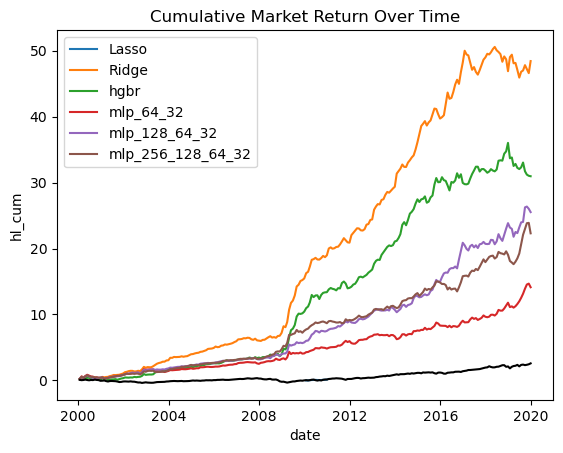

In [189]:
sns.lineplot(data=portfolios, x='date', y='hl_cum', hue='model_name').set_title('Cumulative High-Low Portfolio Spread Returns by Model')
# sns.lineplot(data=portfolios, x='date', y='l_cum', hue='model_name').set_title('Cumulative High-Low Portfolio Returns by Model')
sns.lineplot(data=portfolios, x='date', y='sp500_cumret', color='black', ci=None).set_title('Cumulative Market Return Over Time')

#set lineplot color in sns.lineplot(data=mkt_rf, x='date', y='cumret', ).set_title('Cumulative Market Return (Mkt-RF) Over Time')
import matplotlib.pyplot as plt

plt.legend()
plt.show()

In [32]:
import plotly.express as px
fig = px.line(portfolios, x='date', y='hl_cum', color='model_name',
             title='Cumulative High-Low Portfolio Spread Returns by Model')
fig.show()

In [190]:
print(portfolios['sp500_cumret'])

0       0.081600
1       0.034767
2       0.064568
3       0.124929
4       0.058108
          ...   
1435    2.397830
1436    2.315602
1437    2.368984
1438    2.443775
1439    2.581526
Name: sp500_cumret, Length: 1440, dtype: float64


In [19]:
## generate r2 for each model 
def calculate_r2(bigresults):
    r2_results = {}
    for col in bigresults.columns:
        if col.startswith('pred_'):
            model_name = col[5:]  # Remove 'pred_' prefix
            r2 = r2_score(bigresults['ret'], bigresults[col])
            r2_results[model_name] = r2
    return pd.DataFrame.from_dict(r2_results, orient='index', columns=['R^2']).reset_index().rename(columns={'index': 'Model'})

In [20]:
r2_results = calculate_r2(bigresults)
r2_results

,Model,R^2
0,mlp_128_64_32,-0.166134
1,mlp_256_128_64_32,-0.137070
2,mlp_64_32,-0.217631
3,hgbr,-0.029404
4,Ridge,-0.020980
5,Lasso,0.000674


In [22]:
## get the sharpe ratio for each model
bigresults['date'] = pd.to_datetime(bigresults['date'])  # Ensure date is in datetime format
bigresults = bigresults.merge(mkt_excess, on='date', how='left', validate="many_to_one")  # Merge with market returns

bigresults

def calculate_sharpe_ratio(bigresults):
    sharpe_results = {}
    for col in bigresults.columns:
        if col.startswith('pred_'):
            model_name = col[5:]  # Remove 'pred_' prefix
            excess_returns = bigresults[col] - bigresults['RF'] / 100  # Adjust for risk-free rate
            sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)  # Annualize Sharpe ratio
            sharpe_results[model_name] = sharpe_ratio
    return pd.DataFrame.from_dict(sharpe_results, orient='index', columns=['Sharpe Ratio']).reset_index().rename(columns={'index': 'Model'})
#sharpe_results = calculate_sharpe_ratio(bigresults)

In [23]:
sharpe_results = calculate_sharpe_ratio(bigresults)

In [24]:
sharpe_results

,Model,Sharpe Ratio
0,mlp_128_64_32,0.402966
1,mlp_256_128_64_32,0.097993
2,mlp_64_32,-0.399837
3,hgbr,1.431970
4,Ridge,0.067214
5,Lasso,11.573222


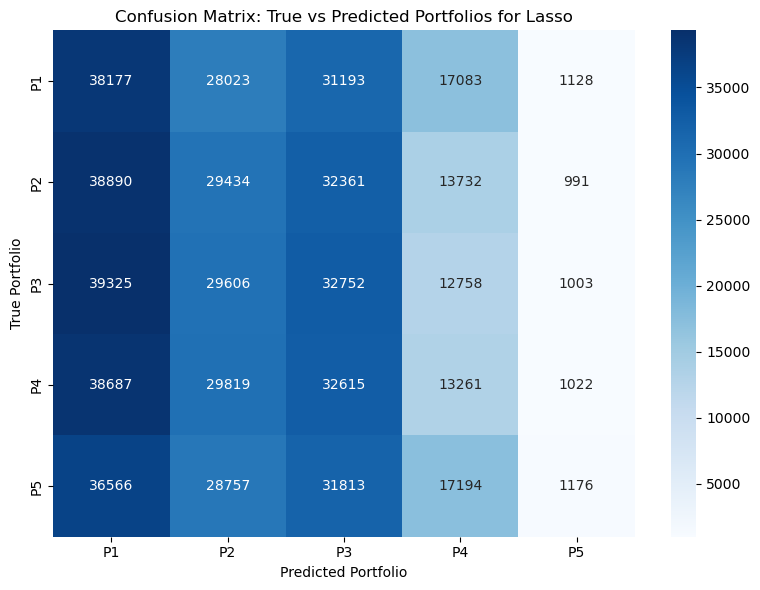

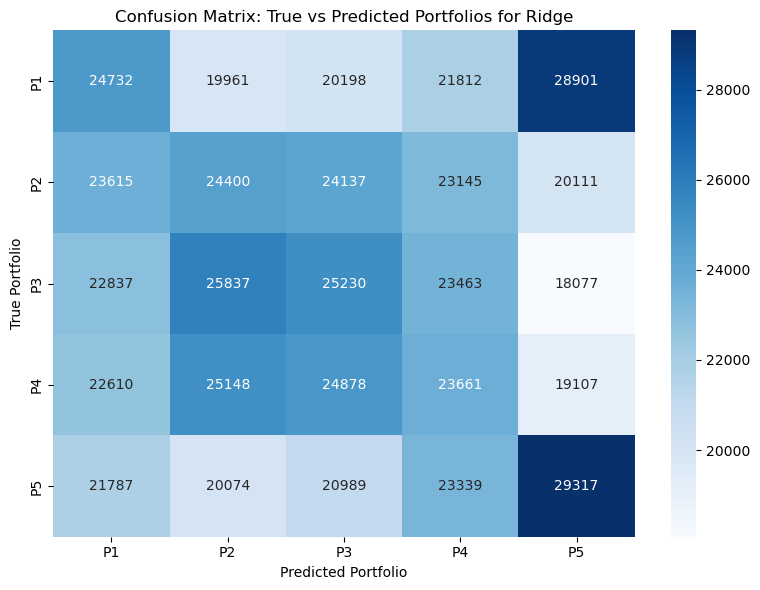

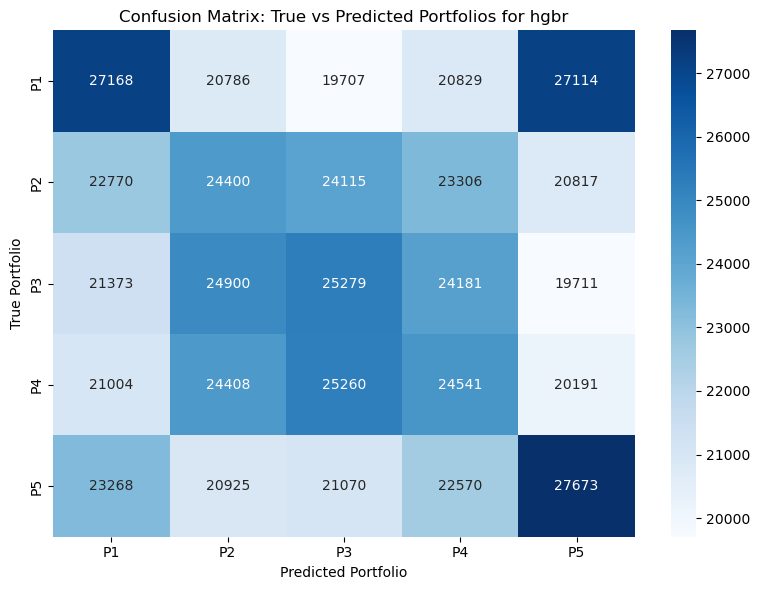

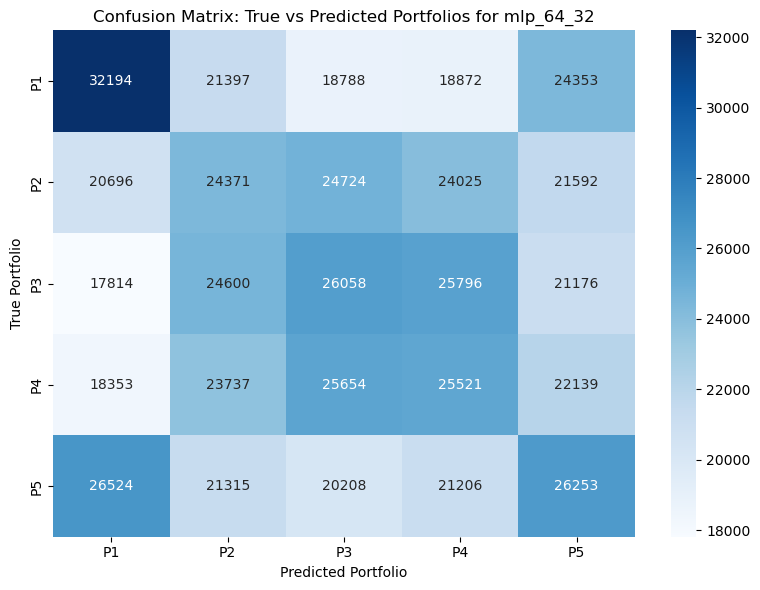

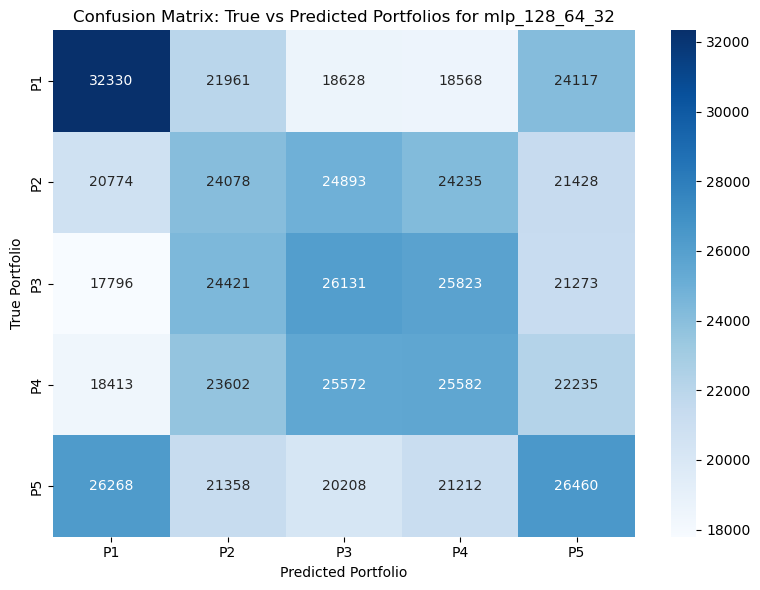

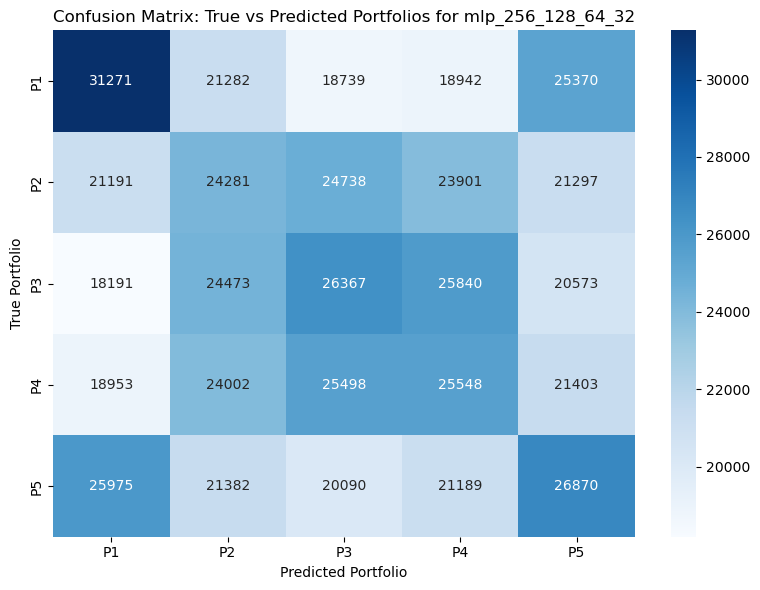

In [ ]:
# bigresults = pd.read_csv('predictions/prediction_output3.csv')

from sklearn.metrics import confusion_matrix

for model in model_dict.keys():
    param_grid = params.get(model, {})
    for param in ParameterGrid(param_grid) or [{}]:  # Handle empty grids
        if model == 'mlp':
            param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
            model_name = f"{model}_{param_suffix}"
        else:
            model_name = model  # Ridge, RF, etc

        pred_col = f'pred_{model_name}'
        port_col = f'port_{model_name}'

        if pred_col not in bigresults.columns:
            print(f"Skipping {model_name}: {pred_col} not found.")
            continue
        nport = 5
        
        # True portfolio: based on actual returns
        bigresults['true_port'] = bigresults.groupby('date')['ret'].transform(
            lambda x: pd.qcut(x, nport, labels=False, duplicates='drop') + 1
        )

        # Predicted portfolio: based on model signal
        

        # Create portfolios based on predictions
        cm = confusion_matrix(bigresults['true_port'], bigresults[port_col])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f'P{p+1}' for p in range(nport)],
                    yticklabels=[f'P{p+1}' for p in range(nport)])
        plt.xlabel('Predicted Portfolio')
        plt.ylabel('True Portfolio')
        plt.title('Confusion Matrix: True vs Predicted Portfolios for ' + model_name)
        plt.tight_layout()
        plt.show()

In [194]:
## Calculate the True Positive Rate (TPR) and False Positive Rate (FPR) for each model for correct bin placement
from sklearn.metrics import recall_score, precision_score
def calculate_tpr_fpr(bigresults):

    tpr_fpr_results = {}
    for col in bigresults.columns:
        if col.startswith('pred_'):
            model_name = col[5:]  # Remove 'pred_' prefix
            # Calculate TPR and FPR
            bigresults['quintile_ret'] = bigresults.groupby('date')['ret'].transform(lambda x: port_sort(x, 5))  # Assuming 5 portfolios
            bigresults[f'quintile_{col}'] = bigresults.groupby('date')[col].transform(lambda x: port_sort(x, 5))  # Assuming 5 portfolios

            y_true = bigresults['quintile_ret'] == 5   # True if return is in the highest quintile (positive return)
            y_pred = bigresults[f'quintile_{col}'] == 5  # Predicted positive return
            
            tpr = recall_score(y_true, y_pred)
            fpr = 1 - precision_score(y_true, y_pred)  # FPR = 1 - Precision
            
            tpr_fpr_results[model_name] = {'TPR': tpr, 'FPR': fpr}
    
    return pd.DataFrame.from_dict(tpr_fpr_results, orient='index').reset_index().rename(columns={'index': 'Model'})

calculate_tpr_fpr(bigresults)



,Model,TPR,FPR
0,mlp_128_64_32,0.228848,0.771162
1,mlp_256_128_64_32,0.232427,0.767583
2,mlp_64_32,0.227140,0.772869
3,hgbr,0.239474,0.760524
4,Ridge,0.253653,0.746358
5,Lasso,0.168091,0.767661


In [29]:
from sklearn.metrics import r2_score, recall_score, precision_score

In [30]:
## Calculate the True Negative Rate (TNR) and False Negative Rate (FNR) for each model for incorrect bin placement
def calculate_tnr_fnr(bigresults):
    tnr_fnr_results = {}
    for col in bigresults.columns:
        if col.startswith('pred_'):
            model_name = col[5:]  # Remove 'pred_' prefix
            # Calculate TNR and FNR
            bigresults['quintile_ret'] = bigresults.groupby('date')['ret'].transform(lambda x: port_sort(x, 5))  # Assuming 5 portfolios
            bigresults[f'quintile_{col}'] = bigresults.groupby('date')[col].transform(lambda x: port_sort(x, 5))  # Assuming 5 portfolios

            y_true = bigresults['quintile_ret'] == 1   # True if return is in the lowest quintile (negative return)
            y_pred = bigresults[f'quintile_{col}'] == 1  # Predicted negative retur
            
            recall_q1 = recall_score(y_true, y_pred) # recall for bin 1
            prec_q1 = precision_score(y_true, y_pred)  # FNR = 1 - Precision
            
            y_true = bigresults['quintile_ret'] == 5
            y_pred = bigresults[f'quintile_{col}'] == 5
            recall_q5 = recall_score(y_true, y_pred)
            prec_q5 = precision_score(y_true, y_pred)
            
            tnr_fnr_results[model_name] = {'recall_q1': recall_q1, 'precision_q1': prec_q1, 'recall_q5': recall_q5, 'precision_q5': prec_q5}

    
    return pd.DataFrame.from_dict(tnr_fnr_results, orient='index').reset_index().rename(columns={'index': 'Model'})
tnr_fnr_results = calculate_tnr_fnr(bigresults)


In [31]:
tnr_fnr_results

,Model,recall_q1,precision_q1,recall_q5,precision_q5
0,mlp_128_64_32,0.279501,0.279544,0.228848,0.228838
1,mlp_256_128_64_32,0.270275,0.270317,0.232427,0.232417
2,mlp_64_32,0.278340,0.278383,0.227140,0.227131
3,hgbr,0.234853,0.234884,0.239474,0.239476
4,Ridge,0.213664,0.213698,0.253653,0.253642
5,Lasso,0.325915,0.198338,0.168091,0.232339


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_55051/2528044334.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


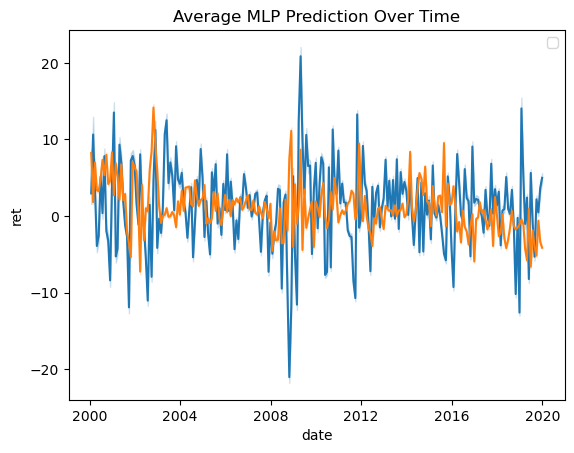

In [93]:
sns.lineplot(data=bigresults, x='date', y='ret').set_title('Average Return Over Time')
sns.lineplot(data=bigresults, x='date', y='pred_mlp_128_64_32').set_title('Average MLP Prediction Over Time')
# sns.lineplot(data=bigresults, x='date', y='pred_hgbr').set_title('Average HistGradientBoostingRegressor Prediction Over Time')
# sns.lineplot(data=bigresults, x='date', y='pred_Ridge').set_title('Average Ridge Prediction Over Time')
# sns.lineplot(data=bigresults, x='date', y='pred_Lasso').set_title('Average Lasso Prediction Over Time')
# sns.lineplot(data=mkt_rf, x='date', y='mkt_excess').set_title(' Average Market Return (Mkt-RF) Over Time')

plt.legend()
plt.show()

In [ ]:
# Average realized return per quintile per date
# port_returns = pred_df.groupby(['date', 'quintile'])['true_return'].mean().unstack()


In [ ]:
# port_returns['H-L'] = port_returns['High'] - port_returns['Low']
# port_returns['H-L'].plot(figsize=(12, 6), title='Average Realized Return by Quintile')

In [ ]:
# # Mean returns
# print("Average Portfolio Returns:")
# print(port_returns.mean())

# # Mean and standard deviation of H-L
# hl_mean = port_returns['H-L'].mean()
# hl_std = port_returns['H-L'].std()

# # Sharpe ratio (assuming monthly data, so scale by sqrt(12) if you want annualized)
# sharpe_ratio = hl_mean / hl_std * (12**0.5)

# print(f"Mean H-L Return: {hl_mean:.4f}")
# print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# OLS -- ML Style Portfolios

In [ ]:
# fit_start = 1975
# fit_end = 2000

# ## Want to find a better way to split and test the model


# ols_pipe = make_pipeline(
#     preproc_pipe,
#     LinearRegression()
# )

# ols_all_year_preds = []
# ols_all_year_true = []
# ols_all_year_dates = []
# ols_all_year_permnos = []

# ols_oof_predictions = np.zeros(len(X_train))  # "Out-of-fold" predictions
# ols_oof_true = np.zeros(len(X_train))          # True y values aligned to validation folds
# fold_r2s = []  # Store R² for each fold

# for fold, (train_idx, val_idx) in enumerate(cv_splits):
    
#     print(f"Training fold {fold+1}/{len(cv_splits)}...")
  
#     # Split into training and validation sets
#     X_train_fold = X_train.iloc[train_idx]
#     y_train_fold = y_train.iloc[train_idx]
#     X_val_fold = X_train.iloc[val_idx]
#     y_val_fold = y_train.iloc[val_idx]
    
#     # Apply preprocessing pipeline to training and validation folds
#     # Special note: if you're using a CrossSectionalMeanImputer, 
#     # you should fit() it on training set only if it was outside pipeline.
#     # But in your case it's inside the preproc_pipe, so fine.

#     X_train_fold = X_train_fold.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
    
#     X_val_fold = X_val_fold.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer
    
#     # Train the pipeline on the training fold
#     ols_pipe.fit(X_train_fold, y_train_fold)
    
#     # Predict on validation fold
#     ols_val_preds = ols_pipe.predict(X_val_fold)
    
#     # Save predictions
#     ols_oof_predictions[val_idx] = ols_val_preds
#     ols_oof_true[val_idx] = y_val_fold
    
#     ols_all_year_preds.append(ols_val_preds)
#     ols_all_year_true.append(y_val_fold.values)
#     ols_all_year_dates.append(X_val_fold.index.get_level_values('date').values)
#     ols_all_year_permnos.append(X_val_fold.index.get_level_values('permno').values)
    
#     r2 = r2_score(y_val_fold, ols_val_preds)
#     fold_r2s.append(r2)



In [ ]:
# ols_all_year_preds = np.concatenate(ols_all_year_preds)
# ols_all_year_true = np.concatenate(ols_all_year_true)
# ols_all_year_dates = np.concatenate(ols_all_year_dates)
# ols_all_year_permnos = np.concatenate(ols_all_year_permnos)

# # Make a DataFrame
# pred_df_ols = pd.DataFrame({
#     'permno': ols_all_year_permnos,
#     'date': ols_all_year_dates,
#     'predicted_return': ols_all_year_preds,
#     'true_return': ols_all_year_true
# })

# pred_df_ols['date'] = pd.to_datetime(pred_df_ols['date'])  # ensure date is datetime
# pred_df_ols['rank'] = pred_df_ols.groupby('date')['predicted_return'].rank(method='first')
# pred_df_ols['quintile'] = pred_df_ols.groupby('date')['rank'].transform(
#     lambda x: pd.qcut(x, 5, labels=['Low', '2', '3', '4', 'High'])
# )

# # Average realized return per quintile per date
# ols_port_returns = pred_df_ols.groupby(['date', 'quintile'])['true_return'].mean().unstack()
# ols_port_returns['H-L'] = ols_port_returns['High'] - ols_port_returns['Low']
# ols_port_returns['H-L'].plot(figsize=(12, 6), title='Average Realized Return by Quintile (OLS)')

# ols_port_returns

In [ ]:
# fold_r2s = np.array(fold_r2s)
# fold_r2s

In [ ]:
# # Compute errors
# mse = mean_squared_error(y_val_fold, val_preds)
# rmse = mse ** 0.5
# mae = mean_absolute_error(y_val_fold, val_preds)
# r2 = r2_score(y_val_fold, val_preds)

# print(f"Validation MSE: {mse:.6f}")
# print(f"Validation RMSE: {rmse:.6f}")
# print(f"Validation MAE: {mae:.6f}")
# print(f"Validation R²: {r2:.4f}")

In [ ]:
# ols_port_returns


# Now Let's Try to put a whole bunch of models together and run it at once

In [ ]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.base import clone
# from sklearn.linear_model import RidgeCV, LassoCV
# from sklearn.metrics import r2_score
# # Different models to try
# models = {
#     'ridge': RidgeCV(),
#     'lasso': LassoCV(),
#     'rf': RandomForestRegressor(),
#     'hgbr': HistGradientBoostingRegressor(),
#     'mlp': mlp, 
    
# }

# # Optional: Parameter grids for each model
# param_grids = {
#     'rf': {'n_estimators': [100, 300]},
#     'hgbr': {'learning_rate': [0.05, 0.1]},
#     'mlp': {
#         'hidden_layer_sizes': [(256, 128, 64), (128, 64), (64,)],
#     }}

# # Storage for results
# results = []

# # Manual loop
# for model_name, base_model in models.items():
#     param_grid = param_grids.get(model_name, {})
#     for params in ParameterGrid(param_grid):
#         print(f"Training {model_name} with params: {params}")

#         # Clone model to not share state
#         model = clone(base_model)
#         model.set_params(**params)

#         fold_r2s = []

#         # Manual CV
#         for train_idx, val_idx in cv_splits:
#             X_train_fold = X_train.iloc[train_idx]
#             y_train_fold = y_train.iloc[train_idx]
#             X_val_fold = X_train.iloc[val_idx]
#             y_val_fold = y_train.iloc[val_idx]

#             # Reset index if needed
#             X_train_fold = X_train_fold.set_index(['permno', 'date'])
#             X_val_fold = X_val_fold.set_index(['permno', 'date'])

#             # Preprocess manually
#             preproc_pipe.fit(X_train_fold)
#             X_train_fold_scaled = preproc_pipe.transform(X_train_fold)
#             X_val_fold_scaled = preproc_pipe.transform(X_val_fold)

#             # Convert to DataFrame if necessary (with feature names)
#             X_train_fold_scaled = pd.DataFrame(X_train_fold_scaled)
#             X_val_fold_scaled = pd.DataFrame(X_val_fold_scaled)

#             model.fit(X_train_fold_scaled, y_train_fold)
#             preds = model.predict(X_val_fold_scaled)

#             fold_r2 = r2_score(y_val_fold, preds)
#             fold_r2s.append(fold_r2)

#         # Save average MSE
#         avg_r2 = np.mean(fold_r2s)
#         results.append((model_name, params, avg_r2))

# # Sort results
# results = sorted(results, key=lambda x: x[2])

# # Print best models
# for model_name, params, r2 in results:
#     print(f"{model_name} {params} - R2: {r2:.5f}")

In [ ]:
# results